In [15]:
from typing import List, Tuple, Union
from datetime import datetime, timedelta
import math
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GCNConv, SAGPooling, global_max_pool, global_mean_pool, GATConv
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from argparse import Namespace
import gc



# loading Data

In [2]:

df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
edges = pd.read_csv('./data/edges.csv')
# 查看test 是否全没有出现
test_no_see_count = len(set(test_df['id'].unique()) - set(df['id'].unique()))
test_no_see_count == test_df['id'].nunique()

# 查看test是否在 edge中出现
no_edge_count = len(
    set(edges['id_1'].tolist() + edges['id_2'].tolist()) - 
    set(test_df['id'].unique()) - 
    set(df['id'].unique())
)


total_node = sorted(set(edges['id_1'].tolist() + edges['id_2'].tolist()))
lb_ecoder = LabelEncoder()
lb_ecoder.fit(np.array(total_node))
edges['id_1_idx'] = lb_ecoder.transform(edges['id_1'])
edges['id_2_idx'] = lb_ecoder.transform(edges['id_2'])


label_df = pd.DataFrame(np.array(total_node), columns=['id'])
label_df['id_idx'] = lb_ecoder.transform(label_df['id'])
label_df = label_df.merge(df, how='left', on='id')
label_df['target'] = label_df['target'].fillna(-1)


# dataLoader

In [3]:

class graphData(InMemoryDataset):
    def __init__(self, root, label_df_in, data_type='train', random_sample_ratio=0.3, random_graph_count=1024):
        self.idx = {
            'train': 0, 'val': 1, 'test': 2
        }[data_type]
        label_df_in = label_df_in.copy(deep=True).sort_values(by='id_idx', ignore_index=True)
        self.mask = torch.tensor(label_df_in['target'] != -1)
        self.node_features = torch.LongTensor(label_df_in['id_idx'].values)
        self.node_label = torch.tensor(label_df_in['target'].values).float()
        self.node_info = label_df_in['id'].values
        self.random_sample_ratio = random_sample_ratio
        self.random_graph_count = random_graph_count
        super().__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[self.idx])


    @property
    def processed_file_names(self):
        return ['edge_processed__tr.dataset', 'edge_processed__val.dataset', 'edge_processed__test.dataset']


    def process(self):
        data_list = []
        if self.idx == 2:
            edges_smaple = edges.reset_index(drop=True).copy(deep=True)
            data = Data(
                x=self.node_features, 
                edge_index=torch.LongTensor(edges_smaple[['id_1_idx', 'id_2_idx']].values.T),
                y=self.node_label,
                mask=self.mask,
                x_info=self.node_info
            )
            data_list.append(data)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[self.idx])  
            return None
        
        # random sample 
        for _ in tqdm(range(self.random_graph_count), total=self.random_graph_count):
            edges_smaple = edges.sample(frac=self.random_sample_ratio, replace=False).reset_index(drop=True)
            data = Data(
                x=self.node_features, 
                edge_index=torch.LongTensor(edges_smaple[['id_1_idx', 'id_2_idx']].values.T),
                y=self.node_label,
                mask=self.mask,
                x_info=self.node_info
            )
            data_list.append(data)


        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[self.idx])   
        return None
        

In [4]:
# dataloader
tr_dataset = graphData('./data/', label_df, data_type='train', random_sample_ratio=0.3, random_graph_count=256)
val_dataset = graphData('./data/', label_df, data_type='val', random_sample_ratio=0.3, random_graph_count=64)
te_dataset = graphData('./data/', label_df, data_type='test', random_sample_ratio=0.3, random_graph_count=64)

Processing...
100%|██████████| 256/256 [00:01<00:00, 134.37it/s]
Done!
Processing...
100%|██████████| 64/64 [00:00<00:00, 131.96it/s]
Done!
Processing...
Done!


# Model 

In [6]:

class GAT(torch.nn.Module):
    def __init__(self, num_emb, emb_dim=128, heads=8, hidden_c=16):
        super().__init__()
        self.node_emb = nn.Embedding(num_embeddings=num_emb, embedding_dim=emb_dim)
        
        self.conv1 = GATConv(emb_dim, hidden_c, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_c * heads, hidden_c, heads, dropout=0.6)
        # self.conv3 = GATConv(hidden_c * heads, hidden_c, heads, dropout=0.6)
        self.conv4 = GATConv(hidden_c * heads, 2, heads=1,
                             concat=False, dropout=0.6)


    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # [b, n, emb_dim]
        x = self.node_emb(x)
        x = x.squeeze(1) 
        
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv4(x, edge_index)
        return x



# Triaining 

In [16]:

def trainer(train_loader, valid_loader, model, config):
    device = config.device
    model.to('cpu')
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr) 
    save_path = config.save_path


    if not os.path.isdir('./models'):
        os.mkdir('./models')


    n_epochs, best_loss, step, early_stop_count = config.n_epochs, math.inf, 0, 0
    ep_val_loss_collect = []
    for epoch in range(n_epochs):
        gc.collect()
        torch.cuda.empty_cache()
        model.train()
        loss_record = []
        train_pbar = tqdm(train_loader, position=0, leave=True)
        train_pbar.set_description(f'Epoch [{epoch+1:02d}/{n_epochs:02d} ]')
        ep_right_count = 0
        tt_count = 0
        for data in train_pbar:
            optimizer.zero_grad() 
            data = data.to(device)
            label = data.y.to(device)
            pred = model(data)
            mask = data.mask
            loss = loss_fn(pred[mask], label[mask].long())
            tt_count += label[mask].size(0)
            ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()
            loss.backward()
            optimizer.step()
            
            step += 1
            l_ = loss.detach().item()
            loss_record.append(l_)
            train_pbar.set_postfix({'loss': f'{l_:.5f}', 'acc': '{:.5f}'.format(ep_right_count/tt_count) })
        
        mean_train_loss = sum(loss_record)/len(loss_record)
        mean_train_acc = ep_right_count/tt_count * 100
        model.eval()
        loss_record = []
        test_accs = []
        ep_right_count = 0
        tt_count = 0
        for data in valid_loader:
            data = data.to(device)
            label = data.y.to(device)
            with torch.no_grad():
                pred = model(data)
                mask = data.mask
                loss = loss_fn(pred[mask], label[mask].long())
                tt_count += label[mask].size(0)
                ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()
            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        mean_valid_acc = ep_right_count/tt_count * 100
        ep_val_loss_collect.append(mean_valid_loss)
        print(f'Epoch [{epoch+1:02d}/{n_epochs:02d}]: Train loss: {mean_train_loss:.4f} Acc: {mean_train_acc:.2f}%  Valid loss: {mean_valid_loss:.4f} Acc: {mean_valid_acc:.2f}%')
        if (epoch+1) % 10 == 0:
            dt_hhmm = datetime.now().strftime('%Y%m%d_%H%M')
            save_path_f = save_path.replace('.ckpt', f'_10ep_{dt_hhmm}.ckpt')
            torch.save(model.state_dict(), save_path_f) 
        
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path) 
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1


        if early_stop_count >= config.early_stop:
            print('\nModel is not improving, so we halt the training session.')
    return ep_val_loss_collect

In [17]:
config = Namespace(
    device='cuda',
    n_epochs=30,
    save_path='./models/gnn.ckpt',
    lr=5e-4,
    batch_size=6,
    early_stop=100,
    
    emb_dim=256,
    heads=8,
    hidden_c=32
)
train_loader = DataLoader(tr_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


# model
model = GAT(num_emb=len(total_node), emb_dim=config.emb_dim, heads=config.heads, hidden_c=config.hidden_c)
loss_record = trainer(train_loader, valid_loader, model, config)

Epoch [01/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s, loss=0.76002, acc=0.69448]


Epoch [01/30]: Train loss: 0.9168 Acc: 69.45%  Valid loss: 0.6054 Acc: 73.82%
Saving model with loss 0.605...


Epoch [02/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s, loss=0.67545, acc=0.71484]


Epoch [02/30]: Train loss: 0.7105 Acc: 71.48%  Valid loss: 0.6003 Acc: 73.88%
Saving model with loss 0.600...


Epoch [03/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.84it/s, loss=0.64141, acc=0.72385]


Epoch [03/30]: Train loss: 0.6570 Acc: 72.39%  Valid loss: 0.5946 Acc: 73.88%
Saving model with loss 0.595...


Epoch [04/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s, loss=0.62179, acc=0.72908]


Epoch [04/30]: Train loss: 0.6307 Acc: 72.91%  Valid loss: 0.5865 Acc: 73.88%
Saving model with loss 0.587...


Epoch [05/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s, loss=0.60648, acc=0.73230]


Epoch [05/30]: Train loss: 0.6113 Acc: 73.23%  Valid loss: 0.5819 Acc: 73.88%
Saving model with loss 0.582...


Epoch [06/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s, loss=0.59450, acc=0.73507]


Epoch [06/30]: Train loss: 0.5994 Acc: 73.51%  Valid loss: 0.5775 Acc: 73.88%
Saving model with loss 0.578...


Epoch [07/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s, loss=0.58706, acc=0.73641]


Epoch [07/30]: Train loss: 0.5909 Acc: 73.64%  Valid loss: 0.5709 Acc: 73.88%
Saving model with loss 0.571...


Epoch [08/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.91it/s, loss=0.58020, acc=0.73717]


Epoch [08/30]: Train loss: 0.5837 Acc: 73.72%  Valid loss: 0.5618 Acc: 73.88%
Saving model with loss 0.562...


Epoch [09/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.91it/s, loss=0.57244, acc=0.73760]


Epoch [09/30]: Train loss: 0.5763 Acc: 73.76%  Valid loss: 0.5498 Acc: 73.88%
Saving model with loss 0.550...


Epoch [10/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.92it/s, loss=0.56454, acc=0.73791]


Epoch [10/30]: Train loss: 0.5681 Acc: 73.79%  Valid loss: 0.5342 Acc: 73.88%
Saving model with loss 0.534...


Epoch [11/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.55529, acc=0.73853]


Epoch [11/30]: Train loss: 0.5589 Acc: 73.85%  Valid loss: 0.5144 Acc: 73.88%
Saving model with loss 0.514...


Epoch [12/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.54355, acc=0.73972]


Epoch [12/30]: Train loss: 0.5489 Acc: 73.97%  Valid loss: 0.4907 Acc: 73.88%
Saving model with loss 0.491...


Epoch [13/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s, loss=0.53136, acc=0.74266]


Epoch [13/30]: Train loss: 0.5370 Acc: 74.27%  Valid loss: 0.4653 Acc: 73.97%
Saving model with loss 0.465...


Epoch [14/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.51749, acc=0.74847]


Epoch [14/30]: Train loss: 0.5234 Acc: 74.85%  Valid loss: 0.4343 Acc: 75.09%
Saving model with loss 0.434...


Epoch [15/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s, loss=0.49928, acc=0.75892]


Epoch [15/30]: Train loss: 0.5078 Acc: 75.89%  Valid loss: 0.3982 Acc: 78.66%
Saving model with loss 0.398...


Epoch [16/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.47992, acc=0.77241]


Epoch [16/30]: Train loss: 0.4902 Acc: 77.24%  Valid loss: 0.3576 Acc: 85.06%
Saving model with loss 0.358...


Epoch [17/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.46156, acc=0.78662]


Epoch [17/30]: Train loss: 0.4710 Acc: 78.66%  Valid loss: 0.3141 Acc: 89.04%
Saving model with loss 0.314...


Epoch [18/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s, loss=0.44589, acc=0.79925]


Epoch [18/30]: Train loss: 0.4521 Acc: 79.93%  Valid loss: 0.2727 Acc: 91.32%
Saving model with loss 0.273...


Epoch [19/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s, loss=0.42917, acc=0.80850]


Epoch [19/30]: Train loss: 0.4355 Acc: 80.85%  Valid loss: 0.2408 Acc: 92.40%
Saving model with loss 0.241...


Epoch [20/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.89it/s, loss=0.41699, acc=0.81476]


Epoch [20/30]: Train loss: 0.4225 Acc: 81.48%  Valid loss: 0.2155 Acc: 93.07%
Saving model with loss 0.216...


Epoch [21/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s, loss=0.40779, acc=0.81924]


Epoch [21/30]: Train loss: 0.4123 Acc: 81.92%  Valid loss: 0.1994 Acc: 93.44%
Saving model with loss 0.199...


Epoch [22/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s, loss=0.40271, acc=0.82192]


Epoch [22/30]: Train loss: 0.4051 Acc: 82.19%  Valid loss: 0.1853 Acc: 93.76%
Saving model with loss 0.185...


Epoch [23/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s, loss=0.39649, acc=0.82459]


Epoch [23/30]: Train loss: 0.3985 Acc: 82.46%  Valid loss: 0.1745 Acc: 94.04%
Saving model with loss 0.174...


Epoch [24/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s, loss=0.39272, acc=0.82608]


Epoch [24/30]: Train loss: 0.3939 Acc: 82.61%  Valid loss: 0.1663 Acc: 94.24%
Saving model with loss 0.166...


Epoch [25/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s, loss=0.38750, acc=0.82765]


Epoch [25/30]: Train loss: 0.3895 Acc: 82.77%  Valid loss: 0.1589 Acc: 94.47%
Saving model with loss 0.159...


Epoch [26/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s, loss=0.38569, acc=0.82877]


Epoch [26/30]: Train loss: 0.3859 Acc: 82.88%  Valid loss: 0.1537 Acc: 94.68%
Saving model with loss 0.154...


Epoch [27/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.92it/s, loss=0.38096, acc=0.83001]


Epoch [27/30]: Train loss: 0.3825 Acc: 83.00%  Valid loss: 0.1481 Acc: 94.87%
Saving model with loss 0.148...


Epoch [28/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.92it/s, loss=0.37790, acc=0.83091]


Epoch [28/30]: Train loss: 0.3796 Acc: 83.09%  Valid loss: 0.1443 Acc: 95.00%
Saving model with loss 0.144...


Epoch [29/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.93it/s, loss=0.37480, acc=0.83166]


Epoch [29/30]: Train loss: 0.3774 Acc: 83.17%  Valid loss: 0.1396 Acc: 95.19%
Saving model with loss 0.140...


Epoch [30/30 ]: 100%|██████████| 43/43 [00:05<00:00,  7.94it/s, loss=0.37370, acc=0.83252]


Epoch [30/30]: Train loss: 0.3749 Acc: 83.25%  Valid loss: 0.1369 Acc: 95.28%
Saving model with loss 0.137...


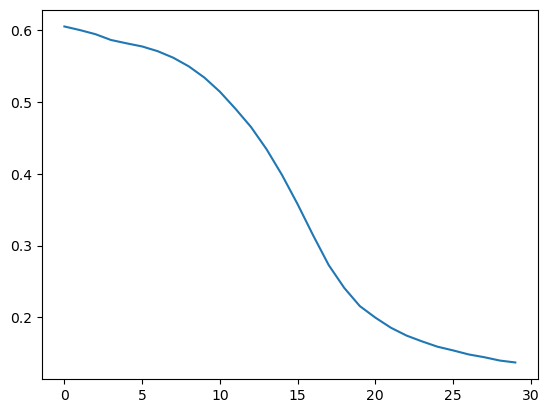

In [18]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.show()

# submit

In [19]:
gc.collect()
torch.cuda.empty_cache()
model.eval()
device = config.device
loss_record = []
test_accs = []
ep_right_count = 0
tt_count = 0
data = te_dataset[0]
data = data.to(device)
label = data.y.to(device)
with torch.no_grad():
    pred = model(data)
    mask = data.mask
    tt_count += label[mask].size(0)
    ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()

In [23]:
res = pd.DataFrame({
'id':  data.x_info,
'target': pred.argmax(dim=1).cpu().detach().numpy()
})
submit_df = pd.read_csv('./data/sample_submit.csv')
sub = submit_df[['id']].merge(res, how='left', on='id')
sub['target'].isna().value_counts()
sub['target'].value_counts()

0    8200
1    1800
Name: target, dtype: int64

In [24]:
sub.to_csv('./data/sub_0919.csv', index=False)